In [1]:
import pandas as pd
import numpy as np
import os
from os import walk
import re
import sys
import getpass
import time

In [7]:
import pandas as pd
import numpy as np
import os
from os import walk
import re
import sys
import getpass
import time


''' Update notes --- Beta V.1.1
Added user more and configuration mode. Configuration mode allows us to reset the dictionary files
Added config file to be able to work with
Pending work:
Change the code for resume logic to be able to handle resume from the start. 
'''
#Function that will import all excel files in a folder
#It will take in the path as input and return a dataframe will contain a concatination of all entries of all three files
def apply_filter(filter_list,df):
    fltr_cnt = len(filter_list)
    print("Applying ",fltr_cnt," filters...")
    try:
        for filter in filter_list:
            df_copy = df.copy()
            filter_data(df_copy,filter)
    except:
        print("Error applying filter")
        sys.exit("Exiting...")
    print("Filters applied successfully")
    return 0

def parse_filter():
    path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"filters.txt"
    try:
        with open(path) as f:
            filt = f.read()
    except:
        print("Error: filters.txt file not found")
        return []
    filter_list = []
    filt=filt.replace('\n',"").replace(" ","").replace("Filter{","").replace("}","").replace("%"," ")
    filt=filt.split(";")
    if len(filt[-1])==0:
        filt.pop()
    for f in filt:
        f = f.split(',')
        f[0] = f[0].replace('FileName=','')
        f[1] = int(f[1].replace('Save=',''))
        f[2] = f[2].replace("(","").replace(")","").replace("[","").replace("]","").split('&')
        f_list = []
        for item in f[2]:
            tup = item.split("=")
            tup[1] = list(tup[1].split("+"))
            tup = tuple(tup)
            f_list.append(tup)
        f_construct = tuple([f[0],f[1],f_list])
        filter_list.append(f_construct)
    return filter_list


def save_df(df,filename):
    print("Attempting to save file...")
    if filename == 'None':
        print('Error: Invalid filename: ',filename)
        sys.exit("Exiting...")
    i=0
    try:
        df.to_csv(filename+".csv")
    except:

        while(i<20):
            try:
                df.to_csv(filename+str(i)+".csv")
            except:
                i=i+1
                continue
            break
    if i<20:
        print("Saved successfully")
    else:
        print("Save Failed. Delete old files if any")

def filter_data(df, filters):
    ''' Filter format is like = (FileName = filename.xlsx,Save = 1 or 0,[(Col,[Val1,Val2]),(Col2,[Val1,Val2])])'''
    print("Applying Filter...")
    filename = filters[0]
    save = filters[1]
    for filter in filters[2]:
        col_name = filter[0]
        values_list = filter[1]
        for i in range(len(list(df.loc[:,'ObjectName'].values))):
            row_ = df.loc[i,col_name]
            if row_ not in values_list:
                df.loc[i,"FilterValue"] = 0
    df = df[df["FilterValue"] == 1]
    if save==1:
        save_df(df,filename)
    return df

def filter_data_v2(df,filters):
    #Efficient but needs to be refined
    print("Applying Filter...")
    filename = filters[0]
    save = filters[1]
    for filter in filters[2]:
        col_name = filter[0]
        val_name = filter[1]
        df = df[df[col_name] == val_name]
    if save==1:
        save_df(df,filename)
    return df

def remove_nan(data_f):
    #Finding the last row of a file. Extra rows with nan entry is removed here. It also combines all the individual data frames 
    #into a single data frame
    #print('Checking for junk values...')
    l = len(data_f)
    junk_frames = []
    for i in range(l):
        if str(data_f.loc[i,'UserAccount']) == 'nan':
            junk_frames.append(i)
    if len(junk_frames)>0:
        # print(len(junk_frames)," junk values found")
        #print("Removing junk frames...")
        data_f.drop(junk_frames,inplace=True)
        #print('Successful.')
    else:
       pass
       # print("No junk frames found.")
       
def parse_config():
    path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"settings.txt"
    try:
        with open(path) as f:
            conf = f.read()
    except:
        print("Error: Settings file not found")
        sys.exit()

    conf = conf.replace(" ","").replace("\n","").replace(';'," ").replace("-{"," ").replace("}","").split()
    conf_dict = {}
    i=0
    while(i<(len(conf))):
        conf_dict[conf[i]] = conf[i+1]
        i=i+2
    return conf_dict

def open_files_of_date(path):
    print("Loading files...")
    f = []
    for(_,_, filenames) in walk(path):
        f.extend(filenames)
        break
    for i in range(6):
        print(f[i])


def update_vocab_file():
    pass


def open_files_in_folder(path):
    #Loading a list of files from a directory
    print("Loading files...")
    f = []
    for (_,_, filenames) in walk(path):
        f.extend(filenames)
        break
    print('Detected ',len(f),' files in the directory')
    dat_frame=[]
    for i in range(len(f)):
        full_path = path+'\\'+f[i]
        #print('Reading File ',f[i])
        dat_f = pd.read_excel(full_path, index_col = None, header = 2,sheet_name=0, skiprows=0)
        remove_nan(dat_f)
        dat_frame.append(dat_f)
        print(str(i+1),'/',str(len(f)),' files read successfully', end='\r')
    print("\n")
    print("All files loaded")
    print("Concatinating files...")
    df_concat = pd.concat(dat_frame, ignore_index = True, sort = False)
    print("File concatination sucessful.")  
    return df_concat
#This helps us to open all the excel files in a folder

def sort_by_time(df):
    time_list = []
    shift_list = []
    for i in list(df.loc[:,"EventTime"].values):
        split_val = i.replace("-"," ").replace(":"," ").split(" ")
        #t_tuple = ((split_val[2]),(split_val[1]),(split_val[0]),(split_val[3]),(split_val[4]),(split_val[5]),0,0,0)
        #print(t_tuple)
        t_tuple = (int(split_val[3]),int(split_val[2]),int(split_val[1]),int(split_val[4]),int(split_val[5]),int(split_val[6]),0,0,0)
        t_ticks = time.mktime(t_tuple)
        time_list.append(t_ticks)
        if (int(split_val[4])>=7) and (int(split_val[4])<15):
            shift_list.append("First Shift")
        elif(int(split_val[4])>=15) and (int(split_val[4])<23):
            shift_list.append("Second Shift")
        else:
            shift_list.append("Night Shift")
    df["Shift"]=shift_list
    df["TimeTicks"]=time_list
    df.sort_values("TimeTicks",inplace=True,ascending=True)

def remove_dupes(df,filter_time_frame):
    pass
    
def path_extraction(df):
    block_list = [] #Block name that comes after root
    seq_list = [] #individual sequence
    change_type = [] #graphics change or logic related
    equip_group = [] #Equipment group
    end_obj = [] #End object
    print("Extracting data from path...")
    for i in list(df.loc[:,"Path"].values):
        loc_split = i.replace("]","/").replace("[Location Structure","Graphic Action").replace("[Control Structure","Control Action").replace("SPB_Block","SPB").replace("WBP_Block","WPB").replace("EmulsionBlock","EB").replace("RB_Block","RB").split("/")
        if loc_split[0]=="Control Action":
            try:
                seq_list.append(loc_split[8])
            except:
                seq_list.append('nan')
            
            try:
                block_list.append(loc_split[3])
            except:
                block_list.append('nan')
                
            try:
                change_type.append(loc_split[0])
            except:
                change_type.append(loc_split[0])
                
            try:    
                equip_group.append(loc_split[7])
            except:
                equip_group.append(loc_split[-2])
                
            try:   
                end_obj.append(loc_split[-1])
            except:
                end_obj.append(loc_split[-1])
        else:
            try:
                block_list.append(loc_split[2])
            except:
                block_list.append('nan')
                
            try:
                change_type.append(loc_split[0])
            except:
                change_type.append('nan')
               
            try:
                end_obj.append(loc_split[-1])
            except:
                end_obj.append('nan')
                
            try:
                equip_group.append(loc_split[3])
            except:
                equip_group.append('nan')
                
            try:
                seq_list.append(loc_split[-2])
            except:
                seq_list.append('nan')  
                
    print("Data Extraction successful")
    print("Adding to Data Frame")
    df["Block"] = block_list
    df["Change_Type"] = change_type
    df["Equipment_Group"] = equip_group
    df["Sequence"] = seq_list
    df["Object_Interacted_With"] = end_obj
    print("Successful")
    
def normalize_user_data(df, file_name = 'Employee_details.xlsx'):
    user_id = []
    user_name = []
    user_dept = []
    user_subdept = []
    user_designation = []
    uknown_id = []
    emp_file_path = os.getcwd()+"\\"+"Utility_Files"+"\\"+file_name
    emp_details = pd.read_excel(emp_file_path, index_col = 0, header = 0).transpose()
    emp_dict = emp_details.to_dict(orient = 'series')
    print("Normalizing User Data")
    for i in list(df.loc[:,"UserAccount"].values):
        id_val = i[11:]
        try:
            emp_details_list = list(emp_dict[id_val].values)
        except:
            if id_val not in uknown_id:
                print("Add user details for ",id_val," in the /Utility_Files/Employee_details.xlsx file")
                uknown_id.append(id_val)
            emp_details_list = ['na','na','na','na']
            
        user_id.append(id_val)
        user_name.append(emp_details_list[0])
        user_designation.append(emp_details_list[1])
        user_dept.append(emp_details_list[2])
        user_subdept.append(emp_details_list[3])
        

    df["UserID"] = user_id  
    df["UserName"] = user_name
    df["UserDesignation"] = user_designation
    df["UserDept"] = user_dept
    df["User_Sub_Dept"] = user_subdept  
    print("Successful")
    del uknown_id

def extract_msg(df):
    message = []
    print("Extracting Message Action")
    for i in list(df.loc[:,"Message"].values):
        msg = i.split()
        message.append(msg[0])
    df["Action_Variable"] = message
    print("Successful")

def normalize_object_name(obj_name):
    import re
    index = re.search("[_]|[-]",obj_name)
    if index is None:
        index = re.search("[0-9]",obj_name)
          
        if index is None:
            split_index = len(obj_name)
        else:
            split_index = index.span(0)[0]
    else:
        split_index = index.span(0)[0]
    
    return obj_name[0:split_index].lower()

def obj_vocab_reader(obj_names, file_name = 'Equip_Vocab.xlsx', refresh = True):
    print("Vocab Building started...Reading file...")
    if (refresh==False):
        obj_vocab_dict_temp={}
        obj_equ_list = {"ID":[],"Object":[],"Object Type":[]}
    else:
        obj_vocab_dict_temp={}
        tmp_df = pd.read_excel(os.getcwd()+"\\"+"Utility_Files"+"\\"+file_name,header = 0, index_col = 0)
        id_list = list(tmp_df["ID"].values)
        object_list = list(tmp_df["Object"])
        object_type_list = list(tmp_df["Object Type"])
        obj_equ_list = {"ID":id_list,"Object":object_list,"Object Type":object_type_list}
        for id_val in id_list:
            obj_vocab_dict_temp[id_val] = None
        print("Refresing vocab file...")
    entry_req = False
    for obj_name in obj_names:
        #We try to split the string at _ first. If _ is not found, then we split at 0-9. If that is not found then we
        #retain the entire string
        index = re.search("[_]|[-]",obj_name)
        if index is None:
            index = re.search("[0-9]",obj_name)
            
            if index is None:
                split_index = len(obj_name)
            else:
                split_index = index.span(0)[0]
        else:
            split_index = index.span(0)[0]
            
        if obj_name[0:split_index].lower() in obj_vocab_dict_temp:
            pass
        else:
            obj_vocab_dict_temp[obj_name[0:split_index].lower()]=None
            obj_equ_list["ID"].append(obj_name[0:split_index].lower())
            obj_equ_list["Object"].append(obj_name)
            obj_equ_list["Object Type"].append(None)
            entry_req = True
            
    if entry_req:
        print("Vocab file needs to be updated...Please make changes in Equip_Vocab.xlsx")
        equip_vocab_df = pd.DataFrame(obj_equ_list)
        equip_vocab_df.to_excel(os.getcwd()+"\\"+"Utility_Files"+"\\"+file_name)
        print("Vocab Building completed...File Saved")
    else:
        print("Vocab file is up to date...")

def object_vocab_file_check(file_name = 'Equip_Vocab.xlsx'):
    
    vocab_df = pd.read_excel(os.getcwd()+"\\"+"Utility_Files"+"\\"+file_name,header=0,index_col=1)
    for i in list(vocab_df.loc[:,"Object Type"]):
        if "nan" == str(i):
            raise Exception("Vocab file has incomplete cells. Complete the vocab file before proceeding forward")
    print("Vocab File Checked...Found OK!")
    vocab_df = vocab_df.drop(columns=["Unnamed: 0","Object"]).to_dict()
    return  vocab_df["Object Type"]

def object_type_builder(df, vocab_df, daily_mode = 0):
    object_type = []
    for object_name in list(df.loc[:,"ObjectName"].values):
        norm_obj_name = normalize_object_name(object_name)
        try:
            object_type.append(vocab_df[norm_obj_name])
        except:
            if daily_mode == 1:
                object_type.append('nan')
            else:
                print("Error: Key Error. Vocab file is not up to date.")
                sys.exit("Exiting...")               
    df["Object_Type"] = object_type
    
def action_definition_dict_build_v2(df):
    """
    #Accepts data frame as input
    #Builds a dictionary of dictionaries. Outputs an excel file which allows us to define actions that are acceptable as MI
    """
    action_var = []
    for i in df.loc[:,"Action_Variable"]:
        action_var.append(i)
    
    action_var_set = set(action_var)
    action_var_set = list(action_var_set)
    definition_set = [None for c in range(len(action_var_set))]
    action_dict={"Action_Value":action_var_set,"Def":definition_set}    
    action_df = pd.DataFrame(action_dict)
    action_df.to_excel(os.getcwd()+"\\"+"Utility_Files"+"\\"+"Action_definition_Final.xlsx")
    
def action_definition(df, action_file_path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"Action_definition_Final.xlsx"):
    """
    #This adds action definition to the data frame
    """
    action_def = pd.read_excel(action_file_path, index_col = 1).drop(columns=["Unnamed: 0"])
    action_dict = action_def.to_dict()
    action_class = []
    for item in df.loc[:,"Action_Variable"]:
        try:
            class_type = str(action_dict["Def"][item])
        except KeyError:
            class_type = "NA"
        else:
            if str(class_type)=='nan':
                class_type = "NA"
        
        force_ret = re.findall("Force",item)
        if len(force_ret)>0:
            class_type = "MI"
        action_class.append(class_type)
    return action_class

def read_config():
    logo_path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"config.txt"
    with open(logo_path) as f:
        print(f.read())

def config_reset():
    path = os.getcwd()     
    path = path + "\\"+ "Operator_Action_Files"+"\\"
    df = open_files_in_folder(path)
    extract_msg(df)
    #oper_data_collective.to_excel('All_oper_action_july.xlsx')

    obj_vocab_reader(list(df.loc[:,"ObjectName"].values), refresh = False) #Reset the equip vocab file
    action_definition_dict_build_v2(df) #Only run this if you want to update the action definition
    print("Equipment Vocab file regenerated. Action Definition regenerated.")
    sys.exit("Exiting...")

def admin_mode_check():
    u_name = getpass.getpass(prompt='Username:')
    p_word = getpass.getpass(prompt='Password:')    
    if u_name == "admin" and p_word =="admin":
        config_reset()
    else:
        print("Invalid Credentials...")
        sys.exit("Exiting...")

def resume_temp():
    temp_path = os.getcwd()+"\\"+"temp"+"\\"+"consolidated_dat.pkl"
    temp_path_1 = os.getcwd()+"\\"+"temp"+"\\"+"combined_dat.pkl"
    print("Loading Temp file...")
    try:
        df = pd.read_pickle(temp_path)        
    except:
        try:    
            df = pd.read_pickle(temp_path_1)
        except:
            print("Temp file load error. Check if temp file is available. Else, start new analysis.")
            print("Press any key to exit...")
            _ = input("")
            sys.exit("Exiting...")
        print("Data loaded successfully.")
        return [0,df]
    print("Temp file loaded successfully.")

    try:
        print("Attempting excel file build operation...")
        df.to_excel("Consolidated_Report.xlsx")
        print("Consolidated report built successfully. Thanks!")

    except:
        print("Excel file build Failed... Attempting csv file build...")
        try:
            df.to_csv("Consolidated_Report.csv")
            print("Consolidated report built successfully. Thanks!")
        except:
            print("CSV Build also failed... Try running from script")
            sys.exit("Exiting...")
    os.remove(temp_path)
    os.remove(temp_path_1)
    print("Press any key to exit...")
    _ = input("")

def print_logo():
    try:
        logo_path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"logo.txt"
        with open(logo_path) as f:
            print(f.read())
    except:
        pass

def detailed_mode():
    print_logo()
    print("Welcome to MI Analysis tool")
    print("Choose your mode of operation")
    print("1. Configuration mode...press 1")
    print("2. User mode...press 2")
    mode = input("")
    if mode == '1':
        admin_mode_check()
    print("_________________________________________________")
    print("User mode selected...Choose execution mode,")
    print("1. Start new analysis")
    print("2. Resume from old analysis")
    ret = 1
    mode = input("")
    if mode == '2':
        r = resume_temp()
        ret = r[0]
        df = r[1]
    if ret == 1:
        vocab_path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"Equip_Vocab.xlsx"
        vocab_df = pd.read_excel(vocab_path,header=0,index_col=1).drop(columns=["Unnamed: 0","Object"]).to_dict()
        object_vocab_file_check()
        path = os.getcwd()     
        path = path + "\\"+ "Operator_Action_Files"+"\\"
        df = open_files_in_folder(path)
        #oper_data_collective.to_excel('All_oper_action_july.xlsx')
        print("Building temp file checkpoint...")
        temp_path_1 =os.getcwd()+"\\"+"temp"+"\\"+"combined_dat.pkl" 
        df.to_pickle(temp_path_1)
        print("Checkpoint created... If unsuccessful, resume from here.")
        r = resume_temp()
        ret = r[0]
        df = r[1]
    if ret == 0:
        obj_vocab_reader(list(df.loc[:,"ObjectName"].values))
        #action_definition_dict_build_v2(df) #Only run this if you want to update the action definition
        path_extraction(df)
        normalize_user_data(df)
        extract_msg(df)
        sort_by_time(df)
        df.drop(columns = "Message")
        object_vocab_file_check()
        object_type_builder(df,vocab_df["Object Type"])
        action_class = action_definition(df)
        df["Action_Class"] = action_class
        df = df.drop(columns=['Unnamed: 0'])
        print("Building temp file checkpoint...")
        temp_path =os.getcwd()+"\\"+"temp"+"\\"+"consolidated_dat.pkl" 
        df.to_pickle(temp_path)
        print("Checkpoint created... If unsuccessful, resume from here.")
        print("Deleting old temp file...")
        os.remove(temp_path_1)
        print("Delete successful")
        print("Building final report...")
        df.to_csv('Consolidated_Report.csv')
        #os.remove(temp_path)
        print("Consolidated report built successfully. Thanks!\nPress any key to exit")
        _ = input("")

def sbt_data_collection():
    vocab_path = settings_dict['Vocab_Path']
    vocab_df = pd.read_excel(vocab_path,header=0,index_col=1).drop(columns=["Unnamed: 0","Object"]).to_dict()
    path = settings_dict['File_Path']
    df = open_files_in_folder(path)
    keep_row = list(np.ones(len(df.loc[:,'ObjectName'].values),dtype=int))
    df["FilterValue"] = keep_row
    path_extraction(df)
    normalize_user_data(df)
    extract_msg(df)
    sort_by_time(df)
    df.drop(columns = "Message")
    object_type_builder(df,vocab_df["Object Type"], daily_mode = 1)
    action_class_path = settings_dict["Action_Class_Path"]
    action_class = action_definition(df,action_file_path=action_class_path)
    df["Action_Class"] = action_class
    df=df.drop(columns=['Unnamed: 0'])
    filter_list = parse_filter()
    apply_filter(filter_list,df)
       

#Main program starts here
print("Reading settings...")
settings_dict = parse_config()
if settings_dict['Daily_Mode']!='1':
    detailed_mode()
else:
    sbt_data_collection()
    


Reading settings...

            _____ _____          _   _ _____        _____ _   _ _______ _____ 
     /\    / ____|_   _|   /\   | \ | |  __ \ /\   |_   _| \ | |__   __/ ____|
    /  \  | (___   | |    /  \  |  \| | |__) /  \    | | |  \| |  | | | (___  
   / /\ \  \___ \  | |   / /\ \ | . ` |  ___/ /\ \   | | | . ` |  | |  \___ \ 
  / ____ \ ____) |_| |_ / ____ \| |\  | |  / ____ \ _| |_| |\  |  | |  ____) |
 /_/    \_\_____/|_____/_/    \_\_| \_|_| /_/    \_\_____|_| \_|  |_| |_____/ 
                                                                             
Welcome to MI Analysis tool
Choose your mode of operation
1. Configuration mode...press 1
2. User mode...press 2
_________________________________________________
User mode selected...Choose execution mode,
1. Start new analysis
2. Resume from old analysis
Vocab File Checked...Found OK!
Loading files...
Detected  10  files in the directory
10 / 10  files read successfully

All files loaded
Concatinating files...
File concat

In [ ]:
def filter_data(df):
    unique_id = []
    for i in range(len(list(df.loc[:,"ObjectName"].values))):
        unique_id = df.loc[i,"ObjectName"]+df.loc[i,"Sequence"]+df.loc[i,"UserID"]
    filt_head = unique_id[0]
    for i in range(1,len(unique_id)):
        if filt_head==unique_id[i]:
            df.drop(index = i, inplace = True)
        else:
            filt_head = unique_id[i]

In [15]:
df2=pd.read_pickle("consolidated_dat.pkl")
print(len(list(df2.loc[:,"ObjectName"].values)))

12169


In [27]:
df3 = df2.drop(index=1)
#83679

Int64Index([    0,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167,
            12168],
           dtype='int64', length=12168)

In [35]:
df2

,EventTime,ObjectName,ObjectDescription,UserAccount,Message,NodeName,FromValue,ToValue,Path,Block,...,UserID,UserName,UserDesignation,UserDept,User_Sub_Dept,Action_Variable,Shift,TimeTicks,Object_Type,Action_Class
0,06-01-2020 06:03:50,XV1_83679,VES-M213 RB Manifold Valve-2,APLKDOMAIN\P00116877,InteractionPar.ManCmd1 False -> True,APLK-RSHS3,False,True,[Control Structure]Root/Control Network SPB/SP...,SPB,...,P00116877,Vinay Prakash,Officer I,Production,RB,InteractionPar.ManCmd1,Night Shift,1.578271e+09,None,NA
1,06-01-2020 06:04:00,XV1_83679,VES-M213 RB Manifold Valve-2,APLKDOMAIN\P00116877,InteractionPar.ManCmd0 False -> True,APLK-RSHS3,False,True,[Location Structure]Root/SPB/ MISCELLANEOUS/DT...,SPB,...,P00116877,Vinay Prakash,Officer I,Production,RB,InteractionPar.ManCmd0,Night Shift,1.578271e+09,None,NA
2,06-01-2020 06:05:31,REAA_M302,MotorUniM,APLKDOMAIN\P00116877,InteractionPar.SetMan False -> True,APLK-RSHS3,False,True,[Control Structure]Root/Control Network RB/RB_...,RB,...,P00116877,Vinay Prakash,Officer I,Production,RB,InteractionPar.SetMan,Night Shift,1.578271e+09,None,NA
3,06-01-2020 06:05:33,REAA_M302,MotorUniM,APLKDOMAIN\P00116877,InteractionPar.ManCmd1 False -> True,APLK-RSHS3,False,True,[Control Structure]Root/Control Network RB/RB_...,RB,...,P00116877,Vinay Prakash,Officer I,Production,RB,InteractionPar.ManCmd1,Night Shift,1.578271e+09,None,NA
4,06-01-2020 06:05:50,Core,NaN,APLKDOMAIN\P00116877,AcquireOnHSI False -> True,APLK-RSHS3,False,True,[Location Structure]Root/RB/RESIN BLOCK/REC-M3...,RB,...,P00116877,Vinay Prakash,Officer I,Production,RB,AcquireOnHSI,Night Shift,1.578271e+09,None,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12164,06-26-2020 04:02:31,XV_07418,WEIGH_HOPPER_XV_07418_SOV,APLKDOMAIN\P00112588,InteractionPar.ManCmd1 False -> True,APLK-RSHS6,False,True,[Control Structure]Root/Control Network RB/RB_...,RB,...,P00112588,Rahul Talware,Diploma OL II,Production,RB,InteractionPar.ManCmd1,Night Shift,1.644100e+09,None,NA
12165,06-26-2020 04:02:32,XV_07418,WEIGH_HOPPER_XV_07418_SOV,APLKDOMAIN\P00112588,InteractionPar.ManCmd1 True -> True,APLK-RSHS6,True,True,[Control Structure]Root/Control Network RB/RB_...,RB,...,P00112588,Rahul Talware,Diploma OL II,Production,RB,InteractionPar.ManCmd1,Night Shift,1.644100e+09,None,NA
12166,06-26-2020 04:02:33,XV_07418,WEIGH_HOPPER_XV_07418_SOV,APLKDOMAIN\P00112588,InteractionPar.ManCmd1 True -> True,APLK-RSHS6,True,True,[Control Structure]Root/Control Network RB/RB_...,RB,...,P00112588,Rahul Talware,Diploma OL II,Production,RB,InteractionPar.ManCmd1,Night Shift,1.644100e+09,None,NA
12167,06-26-2020 04:02:41,Core,NaN,APLKDOMAIN\P00117611,InteractionPar.Hold False -> True,APLK-RSHS2,False,True,[Control Structure]Root/Control Network WPB/WB...,WPB,...,P00117611,Shubham Singh,Officer I,Production,WPB - Proc,InteractionPar.Hold,Night Shift,1.644100e+09,None,NA


In [ ]:
keep_row = list(np.ones(len(list(df.loc[:,'ObjectName'].values)),dtype=int))
df["FilterValue"] = keep_row

In [6]:
df.to_pickle("df_time.pkl")

NameError: name 'df' is not defined

In [ ]:
filter_data(df_test,fil[1])

In [ ]:
def filter_data_v2(df,filters):
    print("Applying Filter...")
    file_name = filters[0]
    save = filter[2]
    for filter in filters[1]:
        col_name = filter[0]
        val_name = filter[1]
        df = df[df[col_name] == val_name]
    if save==1:
        df.to_csv(file_name)
    return df

In [ ]:
def parse_filter():
    path = os.getcwd()+"\\"+"Utility_Files"+"\\"+"filters.txt"
    try:
        with open(path) as f:
            filt = f.read()
    except:
        print("Error: filters.txt file not found")
        return []
    filter_list = []
    filt=filt.replace('\n',"").replace(" ","").replace("Filter{","").replace("}","").replace("%"," ")
    filt=filt.split(";")
    if len(filt[-1])==0:
        filt.pop()
    for f in filt:
        f = f.split(',')
        f[0] = f[0].replace('FileName=','')
        f[1] = int(f[1].replace('Save=',''))
        f[2] = f[2].replace("(","").replace(")","").replace("[","").replace("]","").split('&')
        f_list = []
        for item in f[2]:
            tup = item.split("=")
            tup[1] = list(tup[1].split("+"))
            tup = tuple(tup)
            f_list.append(tup)
        f_construct = tuple([f[0],f[1],f_list])
        filter_list.append(f_construct)
    return filter_list


In [ ]:
fil = parse_filter()

In [ ]:
len(fil)

In [ ]:
df.loc[:,"FilterValue"]

In [ ]:
x

In [ ]:
def filter_data(df, filters):
    ''' Filter format is like = (FileName = filename.xlsx,Save = 1 or 0,[(Col,[Val1,Val2]),(Col2,[Val1,Val2])])'''
    print("Applying Filter...")
    filename = filters[0]
    save = filters[1]
    for filter in filters[2]:
        col_name = filter[0]
        print(col_name)
        values_list = filter[1]
        print(values_list)
        for i in range(len(list(df.loc[:,'ObjectName'].values))):
            row_ = df.loc[i,col_name]
            if row_ not in values_list:
                df.loc[i,"FilterValue"] = 0
    df = df[df["FilterValue"] == 1]
    if save==1:
        save_df(df,filename)
    return df

In [ ]:
conf_dict

In [ ]:
x

In [ ]:
t = tuple([2020, 20, 6, 23, 56, 40, 0, 0, 0])

In [ ]:
t

In [ ]:
x =time.mktime(t)

In [ ]:
x

In [26]:
df3 = df2.copy()

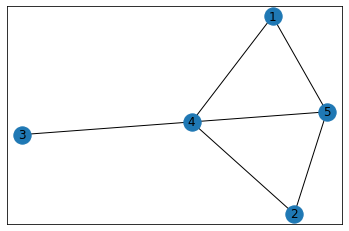

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
# Leave the first line.
command = """
V 5
E {<1,5>,<5,2>,<1,4>,<4,5>,<4,3>,<2,4>,<6,7>}
"""
# Parsing
command_list=command.splitlines()
V_str = command_list[1]
V_str = V_str.replace("V ", "")
V = int(V_str)
E_str = command_list[2]
E_str = E_str.replace("E ","")
E_str = E_str.replace("{","[")
E_str = E_str.replace("}","]")
E_str = E_str.replace("<","(")
E_str = E_str.replace(">",")")
E = eval(E_str)

# Construct Graph V in [1,V]
for i in range(0,V):
    G.add_node(i+1)

for e in E:
    G.add_edge(*e) 
    
nx.draw_networkx(G)